In [1]:
# defaults for Python
import numpy as np
import pandas as pd               # TrackPy results are stored in Pandas dataframes
import matplotlib.pyplot as plt
from matplotlib.patches import Circle

# TrackPy stuff
import trackpy as tp
import pims

# annoying pims warning
import warnings
warnings.filterwarnings("ignore", category=FutureWarning)

# gamma adjust stuff
from skimage.exposure import adjust_gamma
import tifffile

# writing to mp4
import cv2

import os

from scipy import stats

from tqdm import tqdm

# forcing nano scale
from matplotlib.ticker import ScalarFormatter
nano_formatter = ScalarFormatter(useMathText=True)
nano_formatter.set_powerlimits((-9, -9))  # Force e-9

import pymc as pm
import arviz as az

**NOTE:** max sim signal of 799

### Helper functions

In [2]:
# frame adjustment function (based on NIST function):
def adjust_frame(frame, gamma=2, clip_quantile=0.9999):
    tmp = frame.copy().astype(np.float32)
    tmp[tmp > np.quantile(tmp, clip_quantile)] = np.quantile(tmp, clip_quantile)
    #print(np.max(tmp))
    #tmp /= np.max(tmp)
    tmp = adjust_gamma(tmp, gamma)
    #plt.imshow(frame, cmap="grey")
    #plt.show()
    # note that many times values are greater than 65,535
    tmp = np.clip(tmp, 0, 65535).astype(np.uint16)
    return tmp

def overlay(locations, image):
    fig, ax = plt.subplots(figsize=(6, 6))
    ax.imshow(image, cmap='gray')
    
    for _, row in locations.iterrows():
        circ = Circle((row['x'], row['y']), radius=20, edgecolor='red', facecolor='none', linewidth=1)
        ax.add_patch(circ)
    
    plt.show()

def export_annotated_video(tracks, frames, output_path, numbers=True, fps=10, frame_num=True):
    # Make sure x, y are floats
    tracks['x'] = tracks['x'].astype(float)
    tracks['y'] = tracks['y'].astype(float)
    
    # Setup video writer
    frame_size = (frames.frame_shape[1], frames.frame_shape[0])  # width, height
    fourcc = cv2.VideoWriter_fourcc(*'mp4v')
    writer = cv2.VideoWriter(output_path, fourcc, fps, frame_size, isColor=True)
    
    # Normalization and convert to 8bit
    def normalize_and_8bit(img):
        img = img.astype(np.float32)
        img /= img.max() if img.max() > 0 else 1
        return (img * 255).astype(np.uint8)
    
    # go through and annotate all frames
    for i, frame in enumerate(frames):
        img = normalize_and_8bit(frame)
    
        # Convert to BGR for drawing (required by OpenCV)
        img_bgr = cv2.cvtColor(img, cv2.COLOR_GRAY2BGR)

        # draw frame number if option is true
        if frame_num:
            cv2.putText(img_bgr, "frame: " + str(i), (20, 500), cv2.FONT_HERSHEY_SIMPLEX, 1, (0,0,255), 2)
    
        # Draw particle circles for current frame (add numbers if parameter is true)
        particles = tracks[tracks['frame'] == i]
        if numbers == True:
            for _, row in particles.iterrows():
                x, y = int(row['x']), int(row['y'])
                cv2.circle(img_bgr, (x, y), radius=20, color=(0, 0, 255), thickness=3)
                cv2.putText(img_bgr, str(int(row['particle'])), (x+20, y+10), cv2.FONT_HERSHEY_SIMPLEX, 1, (0,0,255), 2)

        else:
            for _, row in particles.iterrows():
                x, y = int(row['x']), int(row['y'])
                cv2.circle(img_bgr, (x, y), radius=20, color=(0, 0, 255), thickness=3)
    
        # Write frame
        writer.write(img_bgr)
    
    writer.release()
    print(f"Saved to {output_path}")

def display_particle(tracks, img, particle_number, frame_number, radius):

    particle_track = tracks[tracks['particle'] == particle_number]
    
    particle_frame = particle_track[particle_track['frame'] == frame_number]
    x, y = int(round(particle_frame['x'])), int(round(particle_frame['y']))
    
    x_min = max(0, x - radius)
    x_max = min(img.shape[1], x + radius)
    y_min = max(0, y - radius)
    y_max = min(img.shape[0], y + radius)
    
    square = img[y_min:y_max, x_min:x_max]
    
    # Create grid for surface plot
    x_range = np.arange(square.shape[1])  # width
    y_range = np.arange(square.shape[0])  # height
    X, Y = np.meshgrid(x_range, y_range)
    
    # Z is intensity
    Z = square
    
    # Plot 3D surface
    fig = plt.figure(figsize=(10, 7))
    ax = fig.add_subplot(111, projection='3d')
    
    surf = ax.plot_surface(X, Y, Z, cmap='viridis', edgecolor='none')
    fig.colorbar(surf, ax=ax, shrink=0.5, aspect=10, label='Pixel Intensity')
    
    ax.set_title(f"particle {particle_number}, x : {x}, y:{y}")
    ax.set_xlabel('X (pixels)')
    ax.set_ylabel('Y (pixels)')
    ax.set_zlabel('Intensity')
    
    plt.tight_layout()
    plt.show()

# Read raw NIST data

In [3]:
NIST_folder = "test_data/Fluorescent_99_nm_polystyrene_in_saline/"

# only use tifs from frame 19 and above
filtered_NISTs = [os.path.join(NIST_folder, f) for f in os.listdir(NIST_folder) if (f.endswith('.tif') and int(f[18:21]) >= 19)]

raw_test = pims.ImageSequence(sorted(filtered_NISTs))


## Adjust raw data to take neighbor's mean for pixels over a threshold

In [4]:
mean_adjusted_folder = "mean_adjusted"
os.makedirs(mean_adjusted_folder, exist_ok=True)

threshold = 2000

mean_adjusted_frames = []

for i, frame in enumerate(raw_test):
    coords = np.argwhere(frame > threshold)

    for y, x in coords:
        # only do for the one hot pixel
        if ((x,y) != (875, 610)):
            #print(x,y)
            continue
        
        y_min, y_max = max(0, y - 1), min(2048, y + 2)
        x_min, x_max = max(0, x - 1), min(2048, x + 2)
        
        neighborhood = frame[y_min:y_max, x_min:x_max]
        neighborhood = neighborhood.flatten()
        neighbors = neighborhood[neighborhood < threshold]
        
        frame[y, x] = int(np.mean(neighbors))

    #print(np.max(frame))

    frame_output_path = os.path.join(mean_adjusted_folder, f"mean_adjusted_{threshold}_frame{i:04d}.tif")
    
    tifffile.imwrite(frame_output_path, frame, dtype=frame.dtype)
    

##### load mean adjusted sequence

In [5]:
test = pims.open(f"{mean_adjusted_folder}/*.tif")

#### Make gamma adjusted for TrackPy visualizations

In [6]:
gamma_adjusted_folder = "gamma_adjusted"
os.makedirs(gamma_adjusted_folder, exist_ok=True)
for i, frame in enumerate(test):
    processed = adjust_frame(frame, gamma=2, clip_quantile=0.9999)
    #print(np.max(frame), np.max(processed), processed.dtype)
    #print(((processed != 0) & (processed != 1)).sum())
    #percentiles(processed)
    tifffile.imwrite(f"{gamma_adjusted_folder}/frame_{i:04d}.tif", processed)

In [7]:
test_adjusted = pims.open(f"{gamma_adjusted_folder}/*.tif")

# Fit simulation parameters to test data 

Mean adjusted test data is stored in "test" pims sequence

Fit parameters to be used in image generation


## Fit backgound noise

Fit background noise with a simple guassian of the pixel values below a threshold percentile

Over the sequence of images, take the average mu and sigma

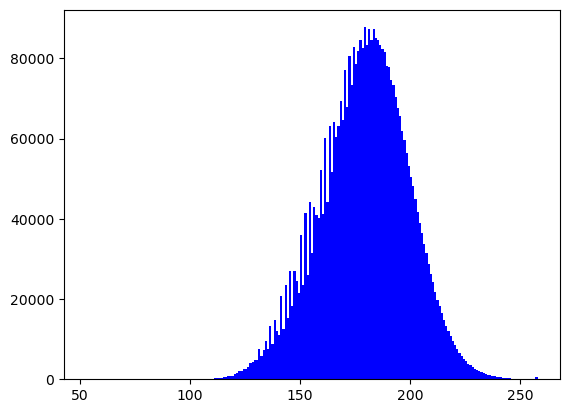

In [8]:
## create background noise image based on clipping

clip_quantile = 0.9999
noise_clip = np.asarray(test[0])
noise_clip[noise_clip > np.quantile(noise_clip, clip_quantile)] = np.quantile(noise_clip, clip_quantile)

hist_min = np.min(noise_clip)
hist_max = np.max(noise_clip)
plt.hist(noise_clip.ravel(), bins=int(hist_max - hist_min), range=(hist_min, hist_max), color='blue')
plt.show()

#### go through entire sequence

In [9]:
fitted_mus = []
fitted_sigmas =[]
KS_ps = []

for frame in tqdm(test):
    clip_quantile = 0.9999
    noise_clip = np.asarray(frame)
    noise_clip[noise_clip > np.quantile(noise_clip, clip_quantile)] = np.quantile(noise_clip, clip_quantile)

    mu, sigma = stats.norm.fit(noise_clip) 

    ks_stat, ks_p = stats.kstest(noise_clip.ravel(), 'norm', args=(mu, sigma))

    fitted_mus.append(mu)
    fitted_sigmas.append(sigma)
    KS_ps.append(ks_p)

100%|████████████████████████████████████████████████████████████████████████████████| 132/132 [00:53<00:00,  2.47it/s]


In [10]:
#plt.plot(fitted_mus)

In [11]:
#plt.plot(fitted_sigmas)

In [117]:
#plt.plot(KS_ps)

In [13]:
fitted_noise_mu = np.mean(np.array(fitted_mus))
fitted_noise_sigma = np.mean(np.array(fitted_sigmas))

print("Background noise fit:")
print("mu:", fitted_noise_mu)
print("sigma:", fitted_noise_sigma)

Background noise fit:
mu: 177.19257854151004
sigma: 19.62560467837437


## Fit guassian blurs of particles

Go through strong TrackPy particle detections


##### Make TrackPy Predictions

In [14]:
video_features = tp.batch(test, diameter=23, minmass=1200);

Frame 131: 27 features


In [15]:
raw_tracks = tp.link(video_features, search_range=20, memory=3)
tracks = tp.filter_stubs(raw_tracks, 20)

Frame 131: 27 trajectories present.


#### Choose Strong Track Identifications to fit

Look at exported track video to choose by hand

For now, I'm just going to use particles that are always present

In [16]:
export_annotated_video(tracks, test_adjusted, "normal_test_adjusted_annotated.mp4", numbers=True, fps=3)

Saved to normal_test_adjusted_annotated.mp4


In [17]:
# get particle nums with detection at every frame:
num_frames = len(tracks['frame'].unique())

full_particles = []
for particle in tracks['particle'].unique():
    particle_df = tracks[tracks["particle"] == particle]

    if len(particle_df) == num_frames:
        full_particles.append(int(particle))

print("Always present particles:", full_particles)

Always present particles: [4, 5, 6, 7, 8, 9, 10, 12, 14, 17, 22, 25, 26, 27, 28, 29, 30, 31]


In [18]:
# looking at exported track video, choose a couple strong predictions
#strong_particle_nums = [19, 17, 20, 1, 7]

column_num = 4

strong_particle_nums = full_particles.copy()
strong_particle_nums.remove(column_num)

strong_tracks = tracks[tracks['particle'].isin(strong_particle_nums)]

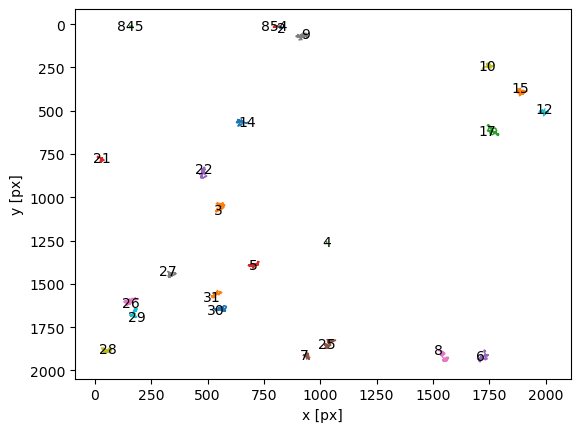

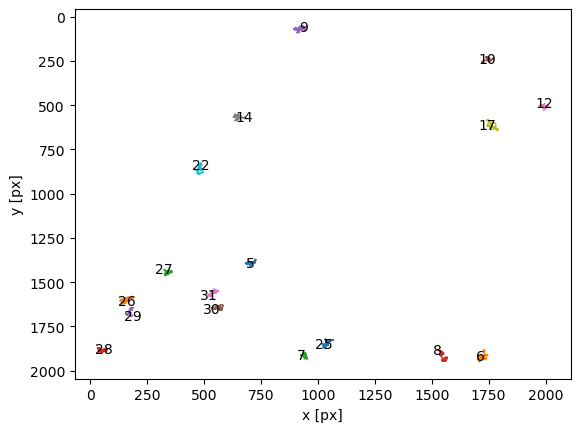

<Axes: xlabel='x [px]', ylabel='y [px]'>

In [19]:
tp.plot_traj(tracks, label=True)
tp.plot_traj(strong_tracks, label=True)

#### Fit strong identifications

Go through chosen strong tracks.

Goal is to see how the distrbution fit changes with signal (peak brightness - background)

2d gaussian fitting is based on this [page](https://fakahil.github.io/coding/how-to-fit-a-2d-gaussian/index.html) with ChatGPT suggesting offset


##### Create helper function to fit gaussian

In [20]:
from scipy.optimize import curve_fit

# Define 2D Gaussian function
def twoD_Gaussian(coords, amplitude, mu_x, mu_y, sigma_x, sigma_y, offset):
    (x, y) = coords
    mu_x = float(mu_x)
    mu_y = float(mu_y)
    g = offset + amplitude * np.exp(
        -(((x - mu_x) ** 2) / (2 * sigma_x ** 2) + ((y - mu_y) ** 2) / (2 * sigma_y ** 2))
    )
    return g.ravel()
    
def fit_2d_gaussian(square):    
    x = np.linspace(0, square.shape[1] - 1, square.shape[1])
    y = np.linspace(0, square.shape[0] - 1, square.shape[0])
    x, y = np.meshgrid(x, y)
    
    # Initial guess (amplitude, xo, yo, sigma_x, sigma_y, offset)
    initial_guess = (square.max(), square.shape[1] // 2, square.shape[0] // 2, 10, 10, square.min())
    
    # Fit
    popt, _ = curve_fit(twoD_Gaussian, (x, y), square.ravel(), p0=initial_guess)

    # force sigmas to be positive:
    popt[3], popt[4] = np.abs(popt[3]), np.abs(popt[4])

    results = {}
    param_names = ["amplitude", "mu_x", "mu_y", "sigma_x", "sigma_y", "offset"]
    for i, param in enumerate(param_names):
        results[param] = popt[i]

    return results

def recreation_code(): # place to store code to remake gaussian blur
    fitted_image = twoD_Gaussian((x, y), *popt).reshape(square.shape)
    
    plt.title("Fitted Gaussian")
    plt.imshow(fitted_image, cmap='gray')
    plt.colorbar()

##### Apply function to particle locations in strong tracks

**note:** curve fit gives multiple covaraiance optimization warnings. I already inspected everything and it seems fine, so just ignore

In [21]:
import warnings
from scipy.optimize import OptimizeWarning

In [22]:
warning_results = []
gaussian_fit_results = []

radius=20

# go through all frame numbers
for frame_num in tqdm(strong_tracks['frame'].unique()):

    curr_frame = np.asarray(test[frame_num])

    frame_particles = strong_tracks[strong_tracks['frame'] == frame_num]
    
    # go through all particles in current frame
    for idx, row in frame_particles.iterrows():
        raw_x, raw_y, signal = np.float64(row['x']), np.float64(row['y']), np.float64(row['signal'])
        
        # get square around location estimation
        x, y = int(raw_x), int(raw_y)
        
        
        x_min = max(0, x - radius)
        x_max = min(curr_frame.shape[1], x + radius)
        y_min = max(0, y - radius)
        y_max = min(curr_frame.shape[0], y + radius)
        
        square = curr_frame[y_min:y_max, x_min:x_max]
        
        #print(raw_x, raw_y)
        #fit_2d_guassian(square)

        try:
            with warnings.catch_warnings():
                warnings.filterwarnings('error', category=OptimizeWarning)
                result = fit_2d_gaussian(square)
                result['signal'] = signal
                result['frame'] = int(frame_num)
                result['particle'] = int(row['particle'])
                gaussian_fit_results.append(result)
        except OptimizeWarning as e:
            warning_results.append(result)
            #print(f"OptimizeWarning at frame {frame_num}, particle number {row['particle']}, coords ({raw_x:.2f}, {raw_y:.2f}): {e}, {signal} {result}")


100%|████████████████████████████████████████████████████████████████████████████████| 132/132 [00:09<00:00, 13.93it/s]


In [23]:
gaussian_fit_results[0]

{'amplitude': np.float64(76.29092913211633),
 'mu_x': np.float64(20.28155683481093),
 'mu_y': np.float64(20.589093016996447),
 'sigma_x': np.float64(2.617695779195994),
 'sigma_y': np.float64(2.316914933703268),
 'offset': np.float64(186.04234516387558),
 'signal': np.float64(60.92469912891843),
 'frame': 0,
 'particle': 5}

##### Plot warning results

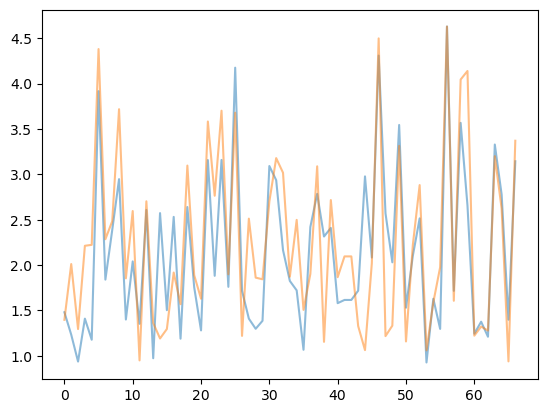

In [24]:
warning_x_sigmas = [r['sigma_x'] for r in warning_results]
warning_y_sigmas = [r['sigma_y'] for r in warning_results]

plt.plot(warning_x_sigmas, alpha=0.5)
plt.plot(warning_y_sigmas, alpha=0.5)
plt.show()


##### Plot overall results

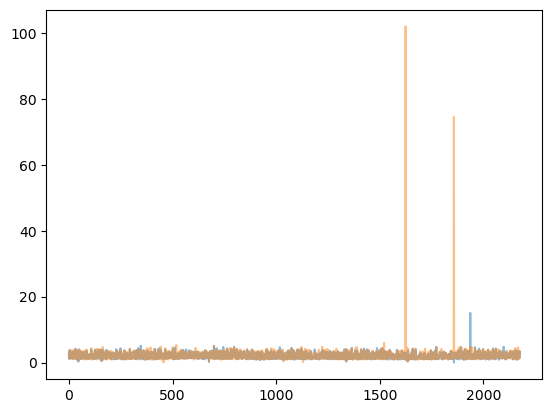

In [25]:
x_sigmas = [r['sigma_x'] for r in gaussian_fit_results]
y_sigmas = [r['sigma_y'] for r in gaussian_fit_results]

plt.plot(x_sigmas, alpha=0.5)
plt.plot(y_sigmas, alpha=0.5)
plt.show()

In [26]:
print("Max x_sigma:", np.max(x_sigmas), "at index:", np.argmax(x_sigmas))
print("Max y_sigma:", np.max(y_sigmas), "at index:", np.argmax(y_sigmas))


Max x_sigma: 15.04764885915596 at index: 1937
Max y_sigma: 101.94334292257389 at index: 1625


In [27]:
gaussian_fit_results[1625]

{'amplitude': np.float64(-11039875.683396019),
 'mu_x': np.float64(30.073638964718153),
 'mu_y': np.float64(-533.2904634968796),
 'sigma_x': np.float64(0.8215011464330801),
 'sigma_y': np.float64(101.94334292257389),
 'offset': np.float64(153.46964455546865),
 'signal': np.float64(87.37649288550185),
 'frame': 98,
 'particle': 26}

In [28]:
#display_particle(strong_tracks, test[98], particle_number=26, frame_number=98, radius=20)

#### For simplicity, just clip sigma estimations

In [29]:
raw_fit_df = pd.DataFrame(gaussian_fit_results)
print(raw_fit_df.shape)
raw_fit_df.head()

(2177, 9)


,amplitude,mu_x,mu_y,sigma_x,sigma_y,offset,signal,frame,particle
0,76.290929,20.281557,20.589093,2.617696,2.316915,186.042345,60.924699,0,5
1,98.096439,19.076583,20.832730,2.106789,1.291482,175.899978,69.894906,0,6
2,1105.400029,20.230408,20.858360,1.180401,1.358609,179.717238,643.880045,0,7
3,52.873111,20.021897,20.831044,3.606285,3.275443,179.153660,46.865153,0,8
4,205.254510,20.752637,20.056462,1.036486,1.461409,181.683453,116.396535,0,9


In [30]:
# pandas returns array ops in series, so I'm typing everything out
clip_low, clip_high = 0.01, 0.99

low_x_sigma_threshold = raw_fit_df['sigma_x'].quantile(clip_low)
high_x_sigma_threshold = raw_fit_df['sigma_x'].quantile(clip_high)
low_y_sigma_threshold = raw_fit_df['sigma_y'].quantile(clip_low)
high_y_sigma_threshold = raw_fit_df['sigma_y'].quantile(clip_high)


print(f"x_sigma cutoffs: ({low_x_sigma_threshold},{high_x_sigma_threshold}),    y_sigma cutoff : ({low_y_sigma_threshold}{high_y_sigma_threshold})")

fit_df = raw_fit_df.copy()
fit_df = fit_df[fit_df['sigma_x'] >= low_x_sigma_threshold]
fit_df = fit_df[fit_df['sigma_x'] <= high_x_sigma_threshold]
fit_df = fit_df[fit_df['sigma_y'] >= low_y_sigma_threshold]
fit_df = fit_df[fit_df['sigma_y'] <= high_y_sigma_threshold]

print(fit_df.shape)
fit_df.head()

x_sigma cutoffs: (0.9041876141959928,4.220218518889633),    y_sigma cutoff : (0.89345012611865064.4469810581730105)
(2100, 9)


,amplitude,mu_x,mu_y,sigma_x,sigma_y,offset,signal,frame,particle
0,76.290929,20.281557,20.589093,2.617696,2.316915,186.042345,60.924699,0,5
1,98.096439,19.076583,20.832730,2.106789,1.291482,175.899978,69.894906,0,6
2,1105.400029,20.230408,20.858360,1.180401,1.358609,179.717238,643.880045,0,7
3,52.873111,20.021897,20.831044,3.606285,3.275443,179.153660,46.865153,0,8
4,205.254510,20.752637,20.056462,1.036486,1.461409,181.683453,116.396535,0,9


##### Plot sigma estimations over signal

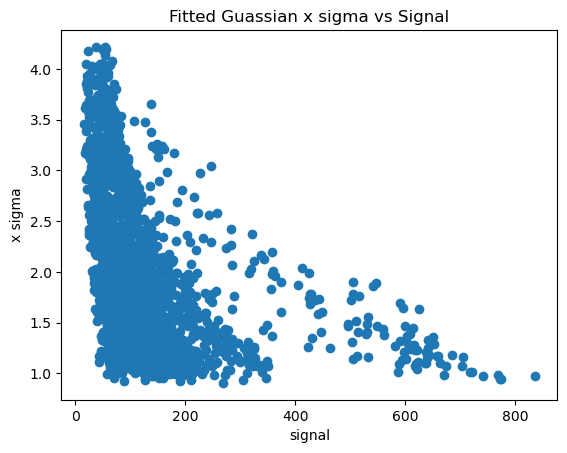

In [31]:
plt.scatter(fit_df['signal'], fit_df['sigma_x'])
plt.xlabel("signal")
plt.ylabel("x sigma")
plt.title("Fitted Guassian x sigma vs Signal")
plt.show()

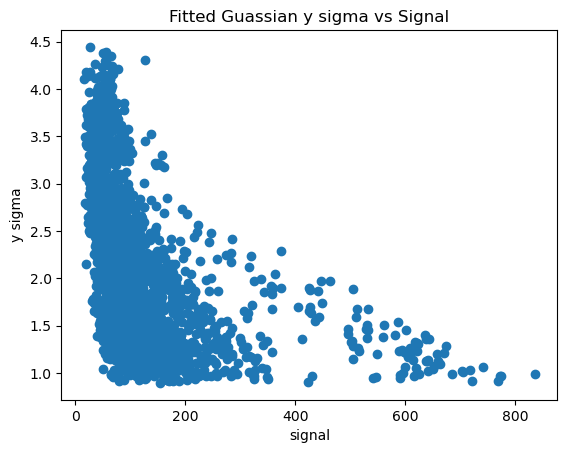

In [32]:
plt.scatter(fit_df['signal'], fit_df['sigma_y'])
plt.xlabel("signal")
plt.ylabel("y sigma")
plt.title("Fitted Guassian y sigma vs Signal")
plt.show()

#### Look at sigma change for individual particles

from before: Always present particles: [4, 5, 6, 7, 8, 9, 10, 12, 14, 17, 22, 25, 26, 27, 28, 29, 30, 31]

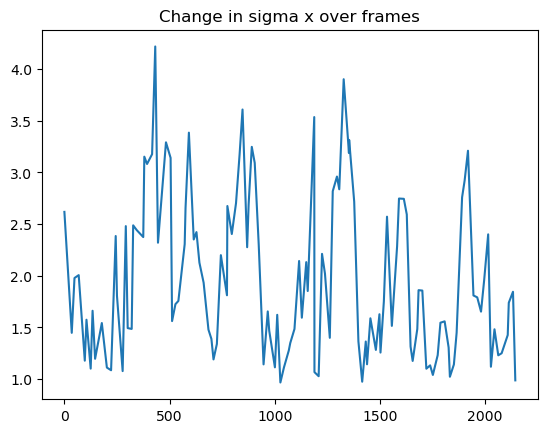

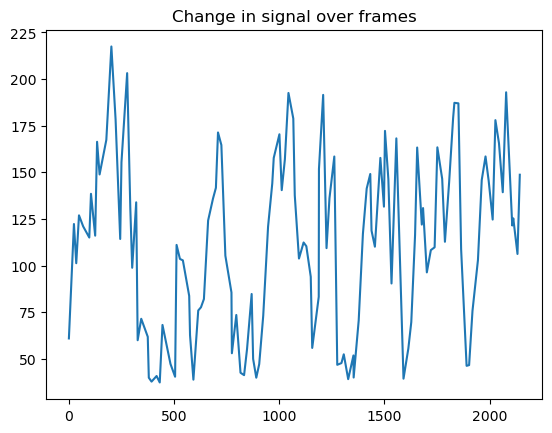

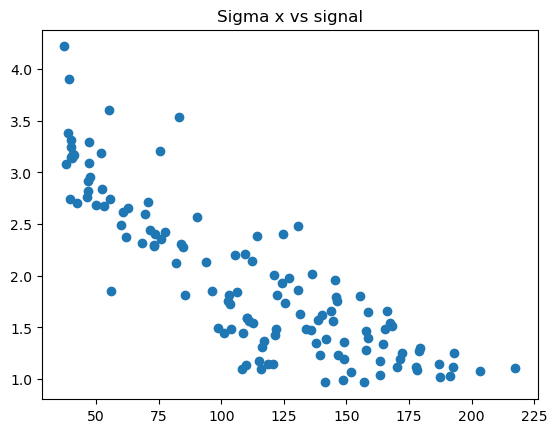

In [33]:
# particle 7 is the high signal particle, but it's signal still varies wildly and gets down to 200
fit_particle_num = 5

fit_particle = fit_df[fit_df['particle'] == fit_particle_num]
fit_particle.head()

plt.plot(fit_particle['sigma_x'])
plt.title("Change in sigma x over frames")
plt.show()

plt.plot(fit_particle['signal'])
plt.title("Change in signal over frames")
plt.show()

plt.scatter(fit_particle['signal'], fit_particle['sigma_x'])
plt.title("Sigma x vs signal")
plt.show()

### Turn this into a distribution

From all of this, it seems like a particle's signal is pretty jumpy.

So in the simulation, we're just going to sample from the signal distrbution prior, and then we'll have the particle's signal change randomly with a cap.

We can then sample from the signal vs sigma prior to get our guassian blur

**current method:**

For time, I'm just going to make bins of the data and sample a gaussian fit to the bin. This is probably not the best for this data and I shuold ask what sample function I should use.

In [34]:
from scipy.stats import gaussian_kde

def kde_signal_sample(fitted, num_samples=1, min_signal=20):
    kde = gaussian_kde(fitted["signal"])

    # Initialize a list to hold valid samples
    valid_samples = []
    
    # Keep drawing until we have enough valid samples
    while len(valid_samples) < num_samples:
        # Draw more than needed to reduce iterations (e.g., 2× oversample)
        new_samples = kde.resample(num_samples).flatten()
        
        # Keep only samples ≥ 20
        filtered = new_samples[new_samples >= 20]
        
        valid_samples.extend(filtered.tolist())
    
    # Slice to desired number and reshape
    final_signals = np.array(valid_samples[:num_samples]).flatten()
    
    if num_samples == 1:
        return final_signals[0]
    else:
        return final_signals
    

def kde_bin_sigma_sample(fitted, signal, sigma_min = 0.89):
    df = fitted.copy()
    
    bin_edges = np.arange(0, df['signal'].max()+50, 50)
    #print(bin_edges)
    df['signal_bin'] = pd.cut(df['signal'], bins=bin_edges)
    
    # Find bin index for the given signal value
    bin_index = np.digitize([signal], bin_edges)[0] - 1
    
    # Handle out-of-range cases
    if bin_index < 0 or bin_index >= len(bin_edges) - 1:
        raise ValueError("Signal value is outside the range of bins.")
    
    # Get bin range and corresponding data
    bin_range = pd.Interval(left=bin_edges[bin_index], right=bin_edges[bin_index+1], closed='right')
    #print(bin_range)
    bin_data = df[df['signal_bin'] == bin_range]['sigma_x']
    
    if len(bin_data) < 2:
        print(f"Not enough data in bin for signal {signal}. Found {len(bin_data)} points. {len(bin_data)}")
        raise ValueError(f"Not enough data in bin for signal {signal}. Found {len(bin_data)} points. {len(bin_data)}")
    
    # Fit KDE on x_sigma values in this bin
    kde = gaussian_kde(bin_data)
    sampled_x_sigma=kde.resample(1).flatten()[0]

    while sampled_x_sigma < sigma_min:
        sampled_x_sigma=kde.resample(1).flatten()[0]

    bin_data = df[df['signal_bin'] == bin_range]['sigma_y']
    
    if len(bin_data) < 2:
        print(f"Not enough data in bin for signal {signal}. Found {len(bin_data)} points. {len(bin_data)}")
        raise ValueError(f"Not enough data in bin for signal {signal}. Found {len(bin_data)} points. {len(bin_data)}")
    
    # Fit KDE on x_sigma values in this bin
    kde = gaussian_kde(bin_data)
    sampled_y_sigma=kde.resample(1).flatten()[0]

    while sampled_y_sigma < sigma_min:
        sampled_y_sigma=kde.resample(1).flatten()[0]

    return {"x_sigma" : sampled_x_sigma, "y_sigma" : sampled_y_sigma}

In [35]:
kde_bin_sigma_sample(fit_df, 799)

{'x_sigma': np.float64(0.9841243366518346),
 'y_sigma': np.float64(1.0026780486169395)}

In [36]:
fit_df['signal'].min()

15.641213016229429

In [37]:
kde_signal_sample(fit_df)

np.float64(118.38983925622395)

$$ $$

$$ $$

$$ $$

$$ $$

$$ $$

$$ $$

$$ $$

$$ $$

$$ $$

$$ $$

# Create simulation

**note:** positions array is in pixels!!!!!

Steps:
- assign radii from normal distribution
- assign uniform random positions 
- use brownian motion equations to simulate positions
- add signal to each particle (make sure is less than 799)
- have signal do a clipped random walk (20, 799) with standard deviation 100


## Simulate Positions with brownian motion

#### helper functions from Inference layouts

In [60]:
def nano(num):
    return num * 10**(-9)

def stokes_einstein(r, t, T_Kelvin, eta):
    # Boltzmann's constant
    k_B = 1.38e-23

    # Calculate diffusion coefficient using Stokes-Einstein relation
    D = (k_B * T_Kelvin) / (6 * np.pi * eta * r)
    
    return D

def no_noise_simulation(positions, radii, num_frames, pixel_size, t=0.1, T_Kelvin=296.55, eta=9.2e-4):
    
    # generate diffusion coefficients
    Ds = stokes_einstein(radii, t, T_Kelvin, eta)
    # calculate sigmas
    variance = 2 * Ds * t
    sigmas = np.sqrt(variance)    
    
    # do wiener step process
    for frame in range(1, num_frames):
        # from previous group:
        move = np.column_stack((np.random.normal(0, sigmas, num_particles), 
                                     np.random.normal(0, sigmas, num_particles)))
        # divide meter movements by pixel size
        pixel_move = move / pixel_size

        # add pixel movements to position array
        positions[frame] = positions[frame - 1] + pixel_move

    return positions

#### set radii and simulate

In [61]:
num_particles = 10
radii = np.random.normal(nano(100), nano(20), num_particles)


# from test data
pixel_size = nano(314.3)
num_frames = 138
sim_res = (2048, 2048)
t = 0.1 #100 ms
T_Celsius = 23.4
T_Kelvin = T_Celsius + 273.15 #C to Kelvin
eta = 9.2e-4


# set initial positions by uniform pixels
positions = np.zeros((num_frames, num_particles, 2))
positions[0, :, 0] = np.random.uniform(0, sim_res[0], num_particles)
positions[0, :, 1] = np.random.uniform(0, sim_res[1], num_particles)

# generate simulated positions
positions = no_noise_simulation(positions, radii, num_frames, pixel_size, t, T_Kelvin, eta)
positions.shape

(138, 10, 2)

#### Simulate signal (unrelated to particle size)

In [62]:
signal_walk_mean = 0
signal_walk_sigma = 50
min_signal = 70
max_signal = 799


signals = np.zeros((num_frames, num_particles, 1))

# assign values from kde signal sampler
starting_signals = kde_signal_sample(fit_df, num_samples=num_particles, min_signal=min_signal)
signals[0,:,0] = starting_signals

# do random walk for signal simulation
for frame in range(1, num_frames):
    # signal walk
    signal_change = np.column_stack((np.random.normal(signal_walk_mean, signal_walk_sigma, num_particles)))
    
    # add signal movements
    signals[frame,:,0] = signals[frame - 1,:,0] + signal_change

    # clip to range
    signals[frame,:,0] = np.clip(signals[frame,:,0], min_signal, max_signal)

#### Append signals as third position

In [63]:
positions_with_signals = np.concatenate((positions, signals), axis=2)

$$ $$

## Generate Images

In [64]:
window_multiplier = 5

particle_mask_noise_mu = 0
particle_mask_noise_sigma = 2
particle_mask_noise_multiplier = 10

def add_particle_mask(frame, particle_x, particle_y, signal):
    # get x_sigma and y_sigma samples based on signal
    sigma_samples = kde_bin_sigma_sample(fit_df, signal)
    sigma_x = sigma_samples['x_sigma']
    sigma_y = sigma_samples['y_sigma']

    
    height, width = frame.shape

    # Define window around particle
    size_x = int(5 * sigma_x)
    size_y = int(5 * sigma_y)
    
    x_min = max(0, int(particle_x - size_x))
    x_max = min(width, int(particle_x + size_x + 1))
    y_min = max(0, int(particle_y - size_y))
    y_max = min(height, int(particle_y + size_y + 1))

    if x_max < 0 or y_max < 0 or x_min > width or y_min > height:
        return

    # Create grid
    x = np.arange(x_min, x_max)
    y = np.arange(y_min, y_max)
    X, Y = np.meshgrid(x, y)
    
    # Evaluate 2D Gaussian
    gaussian_mask = signal * np.exp(
        -(((X - particle_x) ** 2) / (2 * sigma_x ** 2) + ((Y - particle_y) ** 2) / (2 * sigma_y ** 2))
    )

    gaussian_mask = gaussian_mask.astype(np.uint16)


    # add noise directly to particle mask
    mask_with_noise = gaussian_mask + np.random.normal(particle_mask_noise_mu, particle_mask_noise_sigma, size=gaussian_mask.shape)
    mask_with_noise = mask_with_noise.astype(np.uint16)

    # Add particle mask with noise to frame
    frame[y_min:y_max, x_min:x_max] += mask_with_noise

    
    

In [65]:
sim_output_folder = "test_simulation"
os.makedirs(sim_output_folder, exist_ok=True)

# go through and render all frames
# put them in a folder as individual tiff files
for frame_num in tqdm(range(num_frames)):
    # generate fitted background noise
    background = np.random.normal(loc=fitted_noise_mu, scale=fitted_noise_sigma, size=sim_res)
    # clip noise for safety and convert to uint16
    frame = np.clip(background, 0, 65535).astype(np.uint16)
    

    # retrieve positions and signals in the frame
    frame_particles = positions_with_signals[frame_num]

    # render each particle
    for particle in frame_particles:
        particle_mask = add_particle_mask(frame, particle_x = particle[0], particle_y = particle[1], signal = particle[2])

    # save frame
    tifffile.imwrite(f"{sim_output_folder}/frame_{frame_num:04d}.tif", frame)
    


100%|████████████████████████████████████████████████████████████████████████████████| 138/138 [00:15<00:00,  8.69it/s]


## Export information

In [66]:
# save through pandas using datafram
frame_nums = np.repeat(np.arange(num_frames), num_particles)
# np.tile repeats A the given number of times
particle_nums = np.tile(np.arange(num_particles), num_frames)

# Flatten positions array
flat_positions = positions_with_signals.reshape(-1, 3)

# Create DataFrame
sim_ground_df = pd.DataFrame({
    'frame': frame_nums,
    'particle': particle_nums,
    'pixel_x': flat_positions[:, 0],
    'pixel_y': flat_positions[:, 1],
    'signal': flat_positions[:, 2]
})

sim_ground_df['x'] = sim_ground_df['pixel_x'] * pixel_size
sim_ground_df['y'] = sim_ground_df['pixel_y'] * pixel_size

# Add radius by mapping particle index
radius_per_particle = radii[particle_nums]
sim_ground_df['radius'] = radius_per_particle 

# Save to Excel
sim_ground_df.to_excel('simulation_ground_truths.xlsx', index=False)

In [67]:
sim_ground_df.head()

,frame,particle,pixel_x,pixel_y,signal,x,y,radius
0,0,0,1246.623976,1106.913087,32.009353,0.000392,0.000348,1.338034e-07
1,0,1,1423.037268,1026.769531,176.910258,0.000447,0.000323,7.155239e-08
2,0,2,1385.690685,532.371621,88.344043,0.000436,0.000167,8.116653e-08
3,0,3,130.563613,789.022072,106.033496,0.000041,0.000248,4.985771e-08
4,0,4,45.920997,1177.415597,91.067180,0.000014,0.000370,7.342307e-08


In [68]:
positions_with_signals[1]

array([[1243.17781116, 1107.98448242,   70.        ],
       [1422.17967535, 1024.3655248 ,  239.93817179],
       [1387.61897679,  532.42277184,   83.70930886],
       [ 132.23145153,  785.03131782,  116.02137329],
       [  49.2802215 , 1174.33496016,  101.11274563],
       [1816.71006203,  935.06794456,   70.        ],
       [1407.14567679,  529.4625052 ,   70.        ],
       [1812.2508361 ,  476.32925592,   78.18817226],
       [1704.72434751, 1741.68878363,  231.95132464],
       [ 722.74485489, 1879.47412766,  275.37978598]])

$$ $$

$$ $$

$$ $$

$$ $$

$$ $$

$$ $$


$$ $$

$$ $$

$$ $$

$$ $$


$$ $$

# Implement TrackPy on Simulation

## Read simulation with pims

In [69]:
sim = pims.open(f"{sim_output_folder}/*.tif")

## Gamma adjust simulation

In [70]:
sim_gamma_folder = "sim_gamma"
os.makedirs(sim_gamma_folder, exist_ok=True)
for i, frame in enumerate(sim):
    processed = adjust_frame(frame, gamma=2, clip_quantile=0.9999)
    #print(np.max(frame), np.max(processed), processed.dtype)
    #print(((processed != 0) & (processed != 1)).sum())
    #percentiles(processed)
    tifffile.imwrite(f"{sim_gamma_folder}/frame_{i:04d}.tif", processed)

In [71]:
sim_adjusted = pims.open(f"{sim_gamma_folder}/*.tif")

## Apply TrackPy to the simulation data

(13, 9)


array([[<Axes: title={'center': 'x'}>, <Axes: title={'center': 'y'}>]],
      dtype=object)

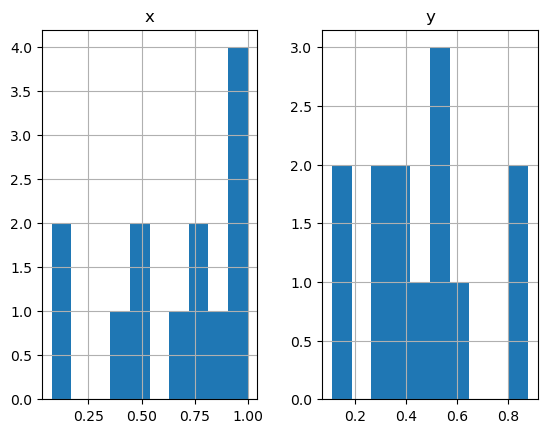

In [72]:
features = tp.locate(sim[0], minmass=1300, diameter = 21)

print(features.shape)
tp.subpx_bias(features)

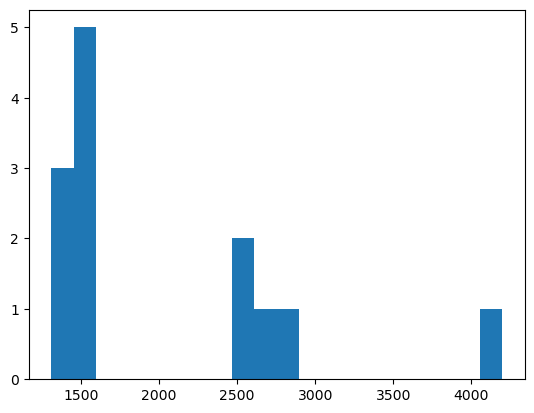

In [73]:
plt.hist(features['mass'], bins=20)
plt.show()

In [74]:
video_features = tp.batch(sim, diameter=21, minmass=1300);

Frame 137: 15 features


In [75]:
raw_tracks = tp.link(video_features, search_range=20, memory=5)
tracks = tp.filter_stubs(raw_tracks, 20)
print('Before:', raw_tracks['particle'].nunique())
print('After:', tracks['particle'].nunique())

Frame 137: 15 trajectories present.
Before: 647
After: 10


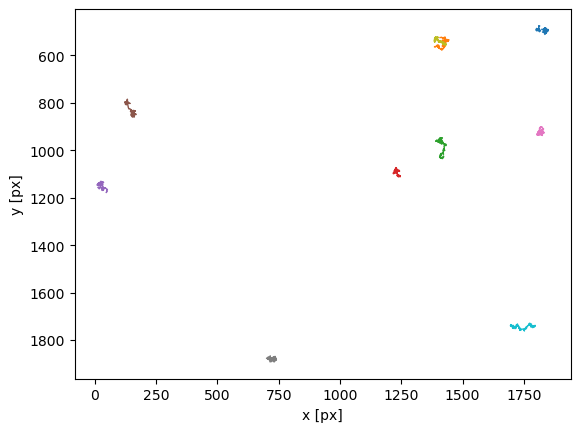

<Axes: xlabel='x [px]', ylabel='y [px]'>

In [76]:
tp.plot_traj(tracks)

In [77]:
export_annotated_video(tracks, sim_adjusted, "normal_sim_adjusted_annotated.mp4", numbers=True, fps=3)

Saved to normal_sim_adjusted_annotated.mp4


In [78]:
# get particle nums with detection at every frame:
num_frames = len(tracks['frame'].unique())

full_particles = []
for particle in tracks['particle'].unique():
    particle_df = tracks[tracks["particle"] == particle]

    if len(particle_df) == num_frames:
        full_particles.append(int(particle))

print("Unique particles:", tracks["particle"].unique())
print()
print("Always present particles:", full_particles)

Unique particles: [ 1  2  3  4  5  6  7  8 10 11]

Always present particles: [4, 6]


$$ $$

$$ $$

$$ $$

## Apply MCMC Estimation on simulation TrackPy output

**note:** looking at gamma adjusted video with current simulation settings, I know that all the filtered tracks are correct. So I'm going to use all of them

#### Load Ground Truth Data and Set Sim Settings

In [79]:
ground = pd.read_excel("simulation_ground_truths.xlsx")

credible_percentage = 0.95

# sim settings
t =  0.1
T_Kelvin = 296.55
eta = 9.2e-4
k_B = 1.38e-23
pixel_size = nano(314.3)

C = (k_B * T_Kelvin * t) / (3 * np.pi * eta)

#### Convert TrackPy Locations


In [80]:
tp_converted = tracks.copy()
tp_converted['x'] = tp_converted['x'] * pixel_size
tp_converted['y'] = tp_converted['y'] * pixel_size

$$ $$

### Single Particle Demo

#### Get Track and Ground Info

In [81]:
# get first frame with all tracks:
full_frame = 0
while len(tp_converted[tp_converted['frame'] == full_frame]) != num_particles:
    full_frame += 1

print(f"First full frame: {full_frame}")

First full frame: 0


In [83]:
tp_particle_num = 1

tp_track = tp_converted[tp_converted['particle'] == tp_particle_num]

tp_track_full = tp_track[tp_track['frame'] == full_frame]
tp_x = tp_track_full['x'].item()
tp_y = tp_track_full['y'].item()

gnd_frame_full = ground[ground['frame'] == full_frame]

# determine ground truth num based on first frame
distances = np.sqrt((gnd_frame_full['x'] - tp_x)**2 + (gnd_frame_full['y'] - tp_y)**2)
closest_ind = np.argmin(distances)
gnd_num = gnd_frame_full.iloc[closest_ind]['particle']

# get ground truth radius:
true_radius = gnd_frame_full[gnd_frame_full['particle'] == gnd_num]['radius'].item()

print("Minimum distance:", np.min(distances))

Minimum distance: 4.538786439972533e-08


#### Determine estimation errors

In [84]:
gnd_track = ground[ground['particle'] == gnd_num]

frames_present = tp_track["frame"]
gnd_present = gnd_track[gnd_track['frame'].isin(frames_present)]

x_errors = tp_track['x'].values - gnd_present['x'].values
y_errors = tp_track['y'].values - gnd_present['y'].values

errors = np.concatenate((x_errors, y_errors))

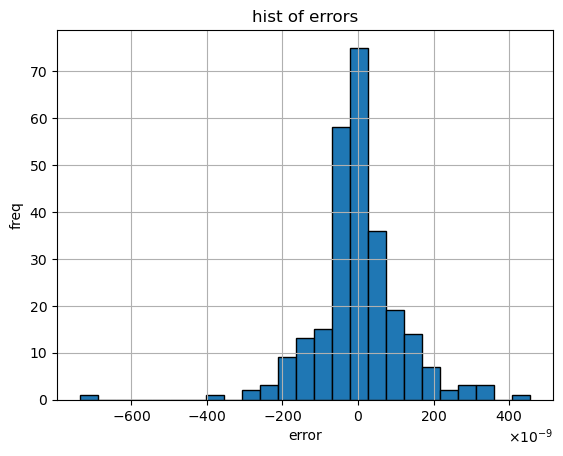

In [85]:
plt.hist(errors, bins=25, edgecolor='black')
plt.title("hist of errors")
plt.gca().xaxis.set_major_formatter(nano_formatter)
plt.xlabel("error")
plt.ylabel("freq")
plt.grid(True)
plt.show()

In [86]:
from scipy.stats import norm

mu_error, sigma_error = norm.fit(errors)
print(mu_error, sigma_error)

3.390832013180606e-10 1.1689786506899923e-07


#### Run MCMC model

Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [sigma2]


Output()

Sampling 4 chains for 10_000 tune and 20_000 draw iterations (40_000 + 80_000 draws total) took 30 seconds.


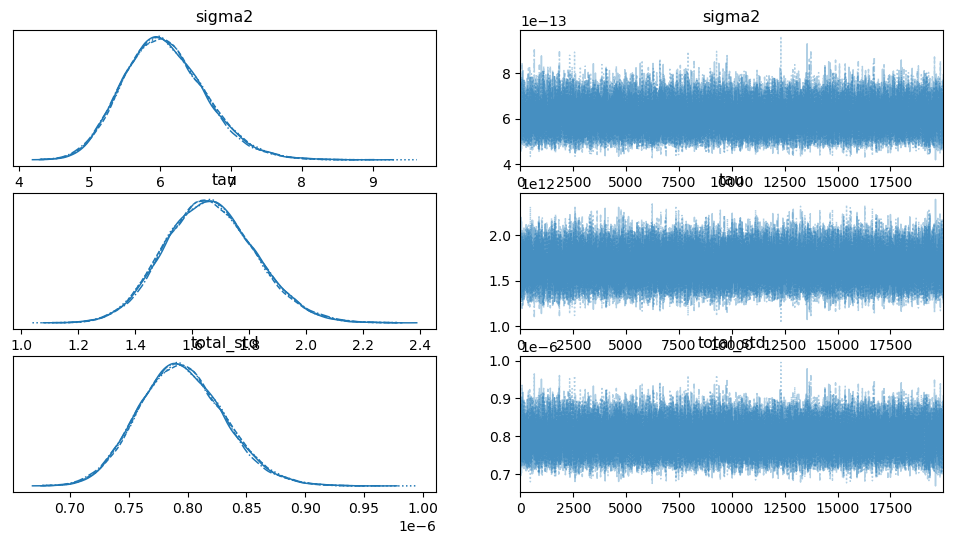

In [94]:
# Extract frame and position arrays
frames = tp_track['frame'].to_numpy()
x_pos = tp_track['x'].to_numpy()
y_pos = tp_track['y'].to_numpy()

# Identify which rows are sequential in frame
frame_diff = np.diff(frames)
sequential_mask = frame_diff == 1  # True where frames are consecutive

# Compute position diffs
x_diff = np.diff(x_pos)
y_diff = np.diff(y_pos)

# Only keep diffs for sequential frame steps
x_dist = x_diff[sequential_mask]
y_dist = y_diff[sequential_mask]

dists = np.concatenate((x_dist, y_dist))

sigma_e2 = sigma_error**2

# PyMC model
with pm.Model() as model:
    # Prior for process variance sigma^2 (can adjust based on domain knowledge)
    sigma2 = pm.HalfCauchy("sigma2", beta=2)
    
    tau = pm.Deterministic("tau", 1 / sigma2)
    
    # Total standard deviation of observed deltas
    total_std = pm.Deterministic("total_std", pm.math.sqrt(sigma2 + 2 * sigma_e2))

    # Likelihood
    obs = pm.Normal("obs", mu=0, sigma=total_std, observed=dists)

    # Run MCMC with NUTS
    trace = pm.sample(draws=20000, tune=10000, chains=4, target_accept=0.9, return_inferencedata=True)

# Posterior summary
az.summary(trace, var_names=["tau"])

# Plot trace
az.plot_trace(trace)
plt.show()

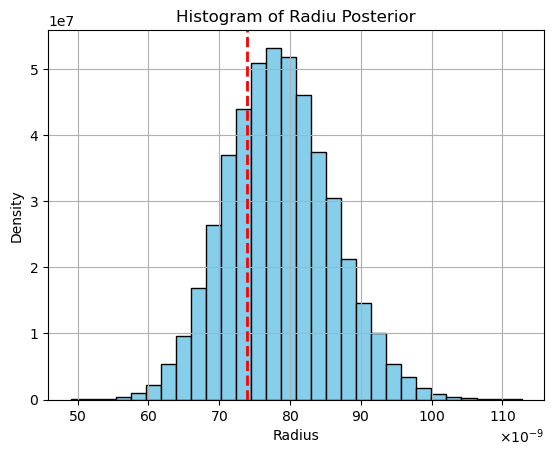

In [95]:
# Step 1: Extract samples of 'tau' from the trace
tau_samples = trace.posterior["tau"].values.flatten()  # shape: (n_samples * n_chains,)

# multiply by C
rad_samples = tau_samples * C

# make histogram
plt.hist(rad_samples, bins=30, density=True, color='skyblue', edgecolor='black')
plt.axvline(x=true_radius, color='red', linestyle='--', linewidth=2)
plt.gca().xaxis.set_major_formatter(nano_formatter)
plt.xlabel("Radius")
plt.ylabel("Density")
plt.title("Histogram of Radiu Posterior")
plt.grid(True)
plt.show()

## Same thing, but assume error variance is 0

Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [sigma2]


Output()

Sampling 4 chains for 10_000 tune and 20_000 draw iterations (40_000 + 80_000 draws total) took 31 seconds.


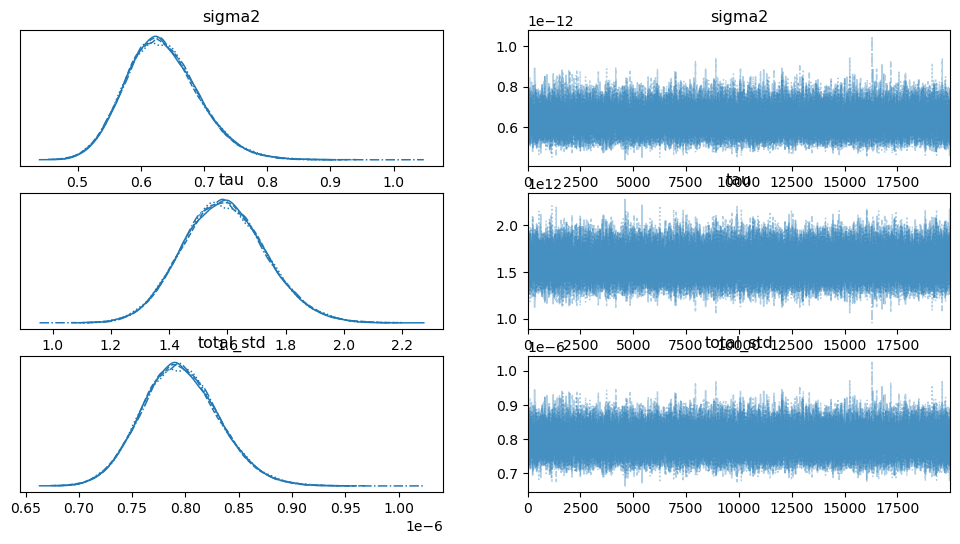

In [96]:
# Extract frame and position arrays
frames = tp_track['frame'].to_numpy()
x_pos = tp_track['x'].to_numpy()
y_pos = tp_track['y'].to_numpy()

# Identify which rows are sequential in frame
frame_diff = np.diff(frames)
sequential_mask = frame_diff == 1  # True where frames are consecutive

# Compute position diffs
x_diff = np.diff(x_pos)
y_diff = np.diff(y_pos)

# Only keep diffs for sequential frame steps
x_dist = x_diff[sequential_mask]
y_dist = y_diff[sequential_mask]
dists = np.concatenate((x_dist, y_dist))

sigma_e2 = 0

# PyMC model
with pm.Model() as model:
    # Prior for process variance sigma^2 (can adjust based on domain knowledge)
    sigma2 = pm.HalfCauchy("sigma2", beta=2)
    
    tau = pm.Deterministic("tau", 1 / sigma2)
    
    # Total standard deviation of observed deltas
    total_std = pm.Deterministic("total_std", pm.math.sqrt(sigma2 + 2 * sigma_e2))

    # Likelihood
    obs = pm.Normal("obs", mu=0, sigma=total_std, observed=dists)

    # Run MCMC with NUTS
    trace = pm.sample(draws=20000, tune=10000, chains=4, target_accept=0.9, return_inferencedata=True)

# Posterior summary
az.summary(trace, var_names=["tau"])

# Plot trace
az.plot_trace(trace)
plt.show()

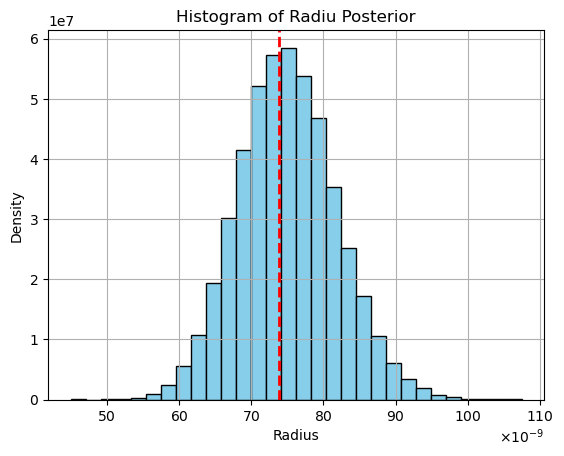

In [97]:
# Step 1: Extract samples of 'tau' from the trace
tau_samples = trace.posterior["tau"].values.flatten()  # shape: (n_samples * n_chains,)

# multiply by C
rad_samples = tau_samples * C

# make histogram
plt.hist(rad_samples, bins=30, density=True, color='skyblue', edgecolor='black')
plt.axvline(x=true_radius, color='red', linestyle='--', linewidth=2)
plt.gca().xaxis.set_major_formatter(nano_formatter)
plt.xlabel("Radius")
plt.ylabel("Density")
plt.title("Histogram of Radiu Posterior")
plt.grid(True)
plt.show()

$$ $$

$$ $$

$$ $$

$$ $$

$$ $$

$$ $$

$$ $$

## Run MCMC demo for all detected particles

#### Helper Functions

In [110]:
def get_ground_info(tp_track, ground, full_frame):
    tp_track_full = tp_track[tp_track['frame'] == full_frame]
    tp_x = tp_track_full['x'].item()
    tp_y = tp_track_full['y'].item()
    
    gnd_frame_full = ground[ground['frame'] == full_frame]
    
    # determine ground truth num based on first frame
    distances = np.sqrt((gnd_frame_full['x'] - tp_x)**2 + (gnd_frame_full['y'] - tp_y)**2)
    closest_ind = np.argmin(distances)
    gnd_num = gnd_frame_full.iloc[closest_ind]['particle']
    
    # get ground truth radius:
    true_radius = gnd_frame_full[gnd_frame_full['particle'] == gnd_num]['radius'].item()
    
    print("Minimum distance:", np.min(distances))

    return [gnd_num, true_radius]

def get_error_info(tp_track, ground, gnd_num):
    gnd_track = ground[ground['particle'] == gnd_num]

    frames_present = tp_track["frame"]
    gnd_present = gnd_track[gnd_track['frame'].isin(frames_present)]
    
    x_errors = tp_track['x'].values - gnd_present['x'].values
    y_errors = tp_track['y'].values - gnd_present['y'].values
    
    errors = np.concatenate((x_errors, y_errors))



    
    plt.hist(errors, bins=25, edgecolor='black')
    plt.title("hist of errors")
    plt.gca().xaxis.set_major_formatter(nano_formatter)
    plt.xlabel("error")
    plt.ylabel("freq")
    plt.grid(True)
    plt.show()


    mu_error, sigma_error = norm.fit(errors)

    return[mu_error, sigma_error]

def run_MCMC_with_error(tp_track, sigma_e2, true_radius, C, show_summary=True):
    # Extract frame and position arrays
    frames = tp_track['frame'].to_numpy()
    x_pos = tp_track['x'].to_numpy()
    y_pos = tp_track['y'].to_numpy()
    
    # Identify which rows are sequential in frame
    frame_diff = np.diff(frames)
    sequential_mask = frame_diff == 1  # True where frames are consecutive
    
    # Compute position diffs
    x_diff = np.diff(x_pos)
    y_diff = np.diff(y_pos)
    
    # Only keep diffs for sequential frame steps
    x_dist = x_diff[sequential_mask]
    y_dist = y_diff[sequential_mask]
    dists = np.concatenate((x_dist, y_dist))
    
    sigma_e2 = 0
    
    # PyMC model
    with pm.Model() as model:
        # Prior for process variance sigma^2 (can adjust based on domain knowledge)
        sigma2 = pm.HalfCauchy("sigma2", beta=2)
        
        tau = pm.Deterministic("tau", 1 / sigma2)
        
        # Total standard deviation of observed deltas
        total_std = pm.Deterministic("total_std", pm.math.sqrt(sigma2 + 2 * sigma_e2))
    
        # Likelihood
        obs = pm.Normal("obs", mu=0, sigma=total_std, observed=dists)
    
        # Run MCMC with NUTS
        trace = pm.sample(draws=20000, tune=10000, chains=4, target_accept=0.9, return_inferencedata=True, nuts_sampler="numpyro", progressbar=False)
    
    # Posterior summary
    if show_summary:
        az.summary(trace, var_names=["tau"])
    
        # Plot trace
        az.plot_trace(trace)
        plt.show()


    # Step 1: Extract samples of 'tau' from the trace
    tau_samples = trace.posterior["tau"].values.flatten()  # shape: (n_samples * n_chains,)
    
    # multiply by C
    rad_samples = tau_samples * C
    
    # make histogram
    plt.hist(rad_samples, bins=30, density=True, color='skyblue', edgecolor='black')
    plt.axvline(x=true_radius, color='red', linestyle='--', linewidth=2)
    plt.gca().xaxis.set_major_formatter(nano_formatter)
    plt.xlabel("Radius")
    plt.ylabel("Density")
    plt.title("Histogram of Radiu Posterior")
    plt.grid(True)
    plt.show()
    

#### Running everything:

Particle 1, detections : 131
Minimum distance: 4.538786439972533e-08


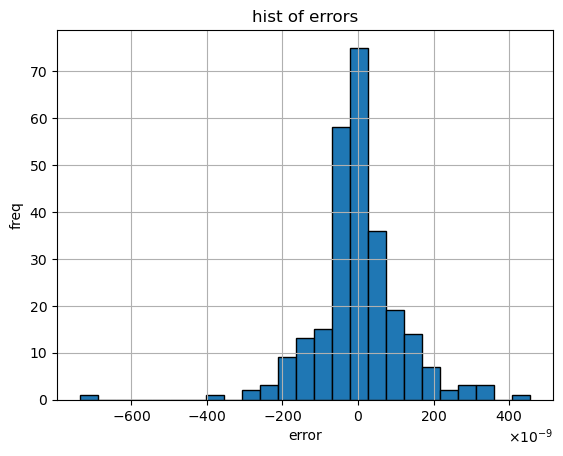

mu_error: 3.390832013180606e-10,      sigma_error : 1.1689786506899923e-07


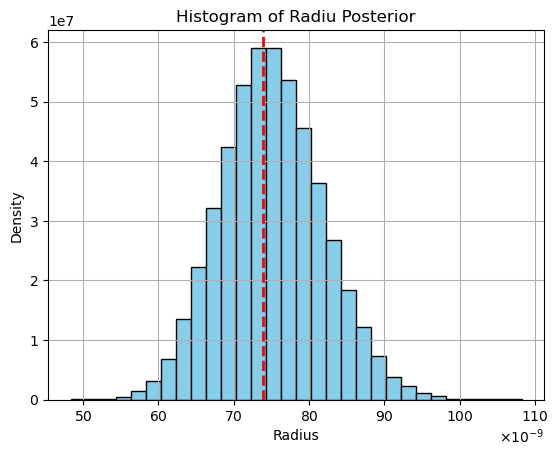

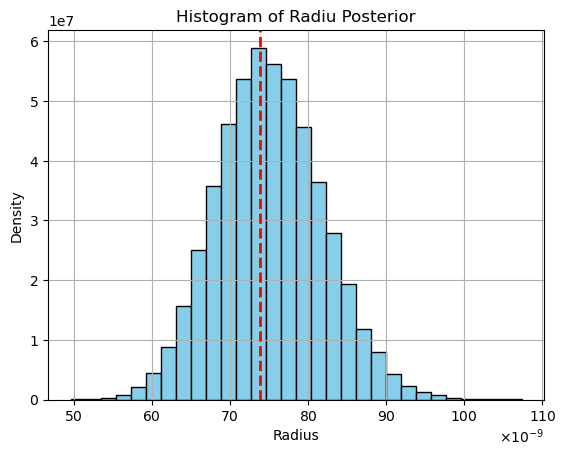

Particle 2, detections : 137
Minimum distance: 1.4920190964996102e-07


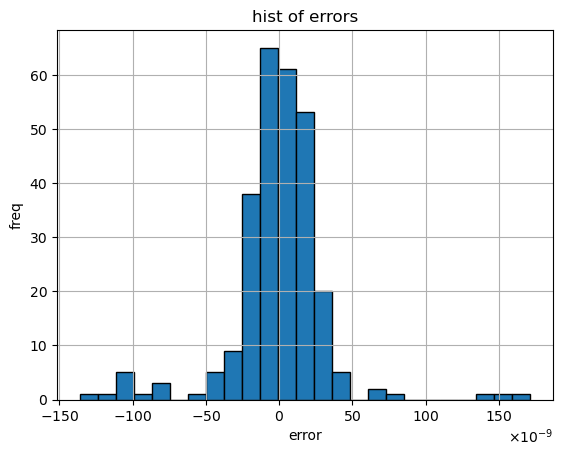

mu_error: -7.08994630748067e-10,      sigma_error : 3.2268183474492594e-08


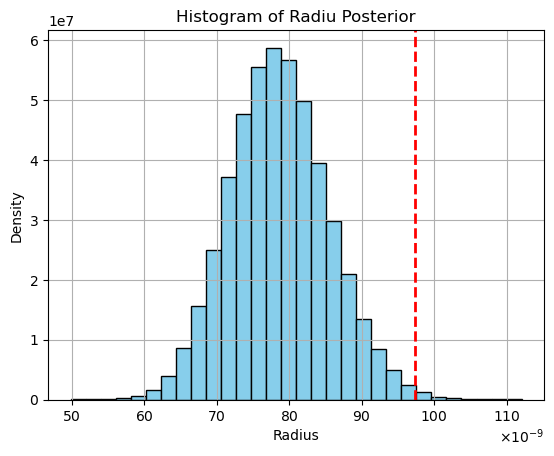

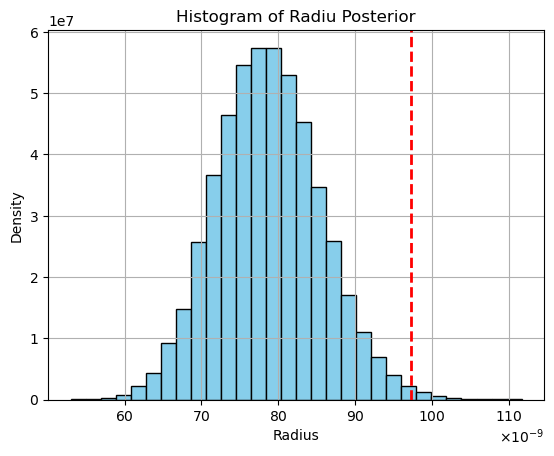

Particle 3, detections : 134
Minimum distance: 1.074732854321228e-07


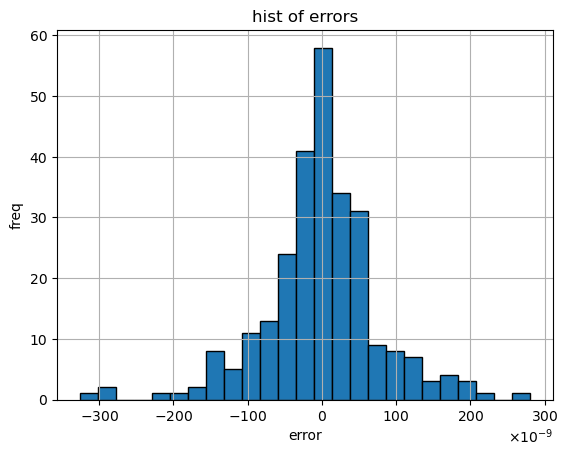

mu_error: -1.4389803276903971e-09,      sigma_error : 7.77181732756511e-08


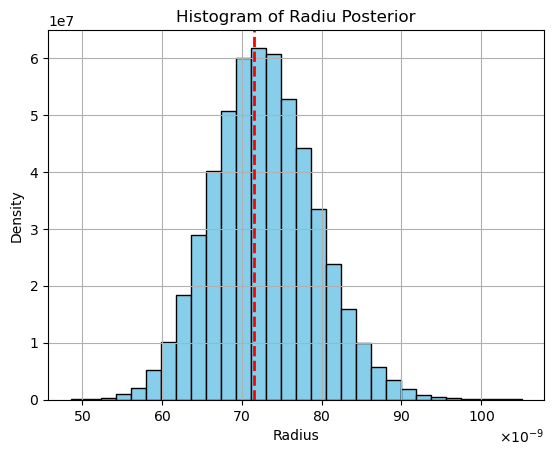

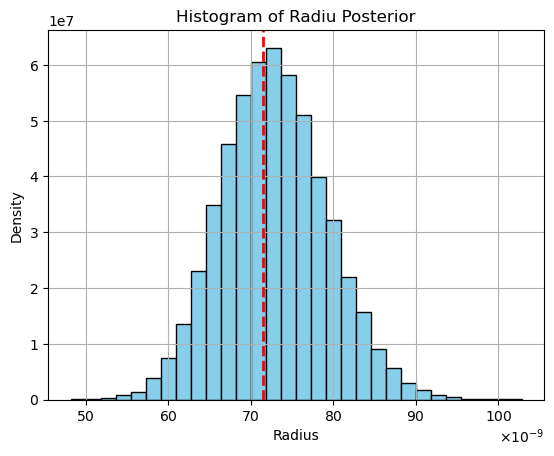

Particle 4, detections : 138
Minimum distance: 3.8765418152165814e-07


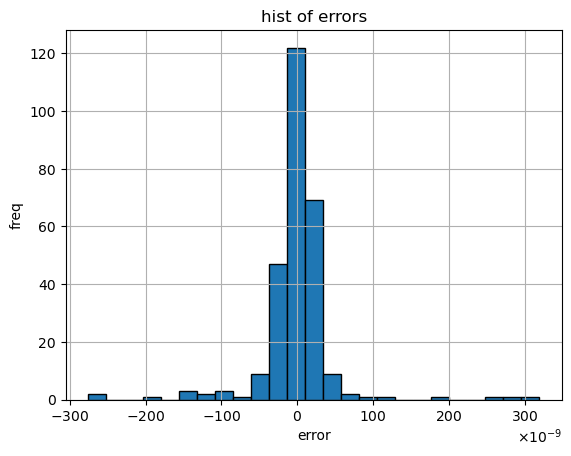

mu_error: -7.581460634160413e-10,      sigma_error : 5.158669457808063e-08


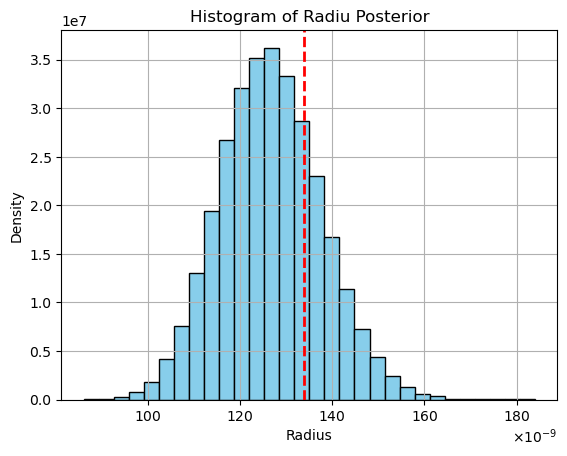

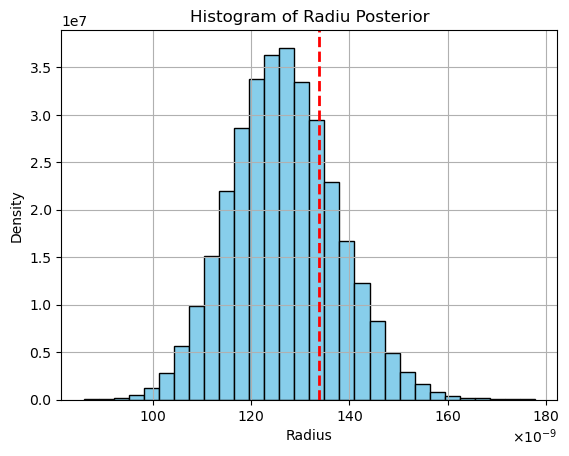

Particle 5, detections : 134
Minimum distance: 6.564147178348987e-08


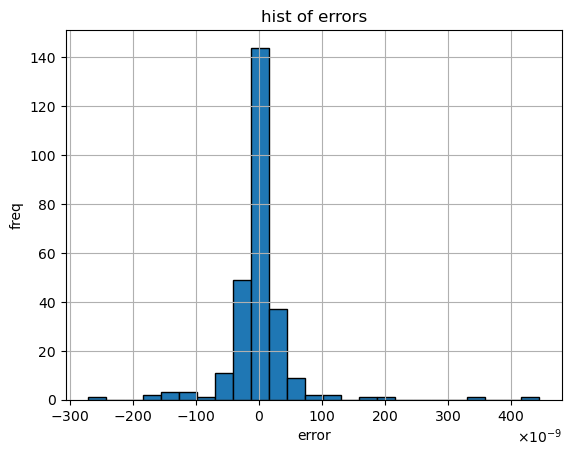

mu_error: 1.9734805463626722e-10,      sigma_error : 5.4932161994648066e-08


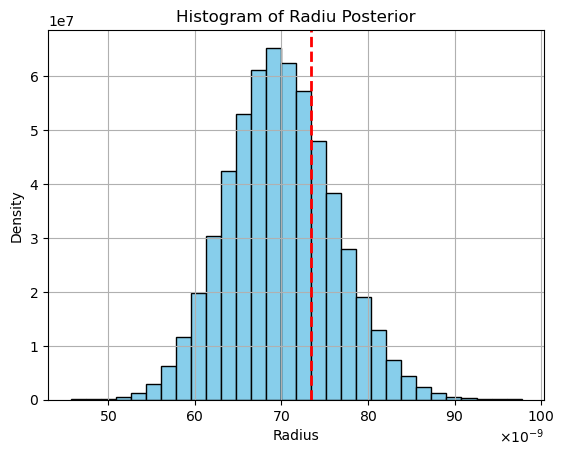

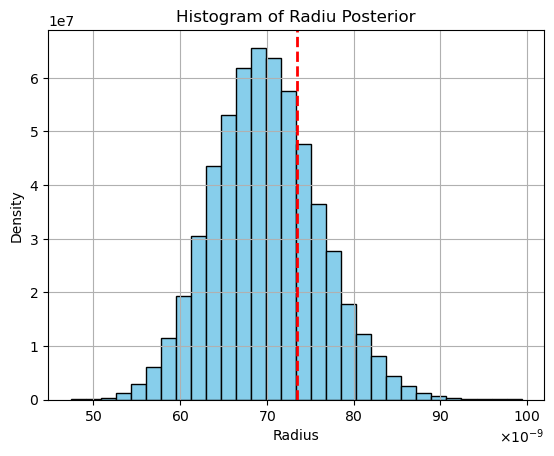

Particle 6, detections : 138
Minimum distance: 2.271317559089742e-07


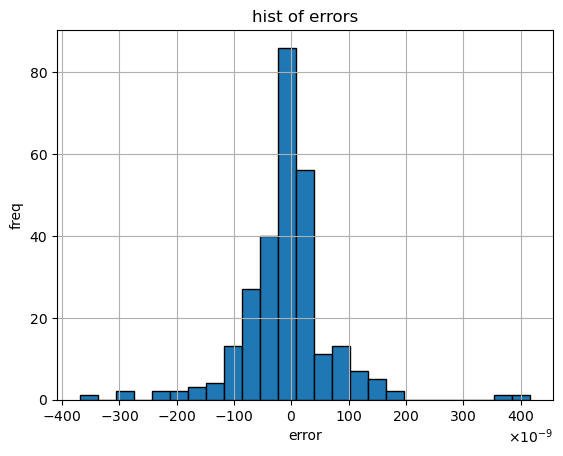

mu_error: -8.733653776135943e-09,      sigma_error : 7.85145657850449e-08


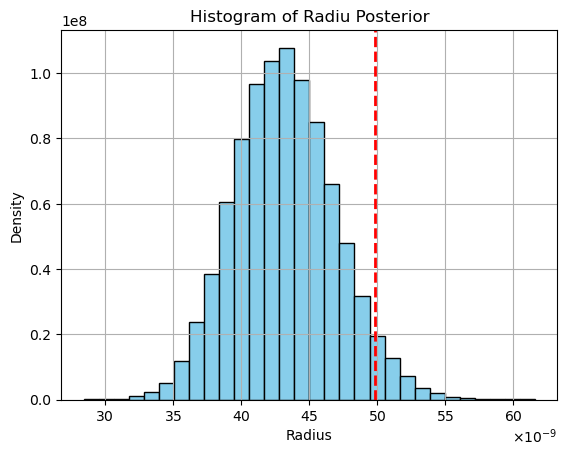

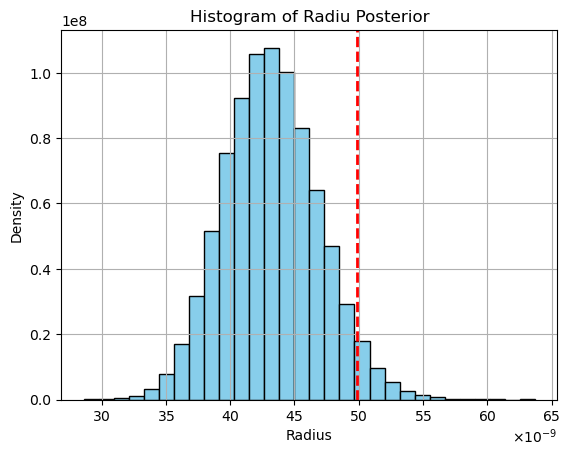

Particle 7, detections : 135
Minimum distance: 1.0612746207967437e-07


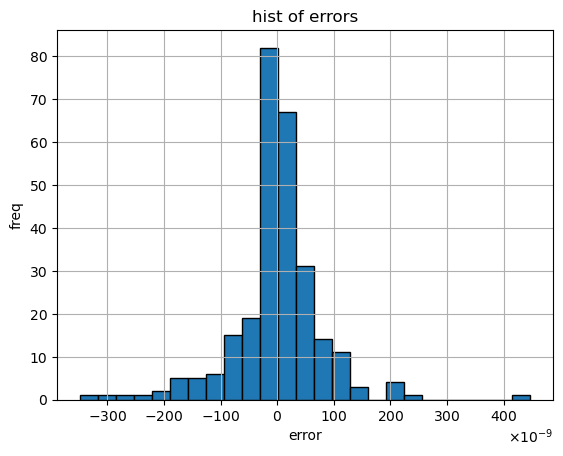

mu_error: -3.7813018525124367e-10,      sigma_error : 7.924504823805086e-08


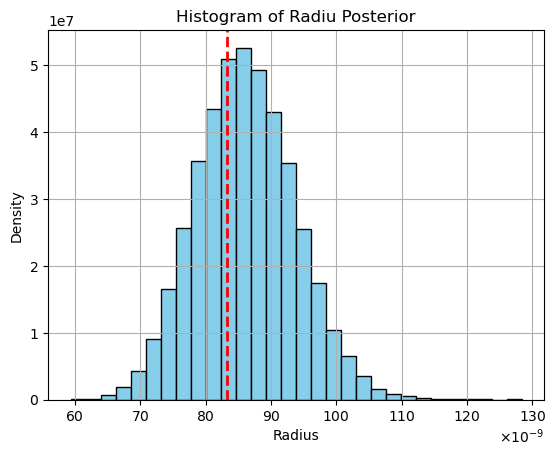

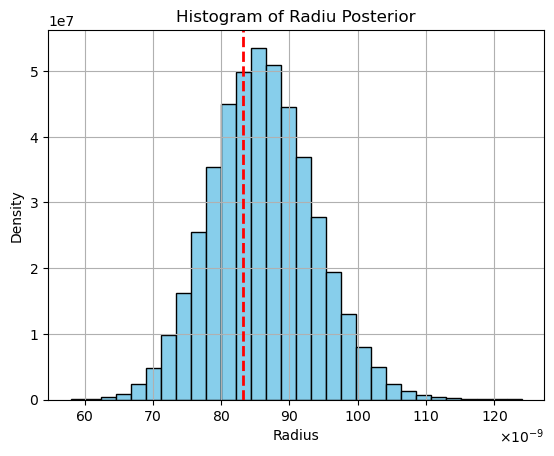

Particle 8, detections : 137
Minimum distance: 2.3894750970449446e-08


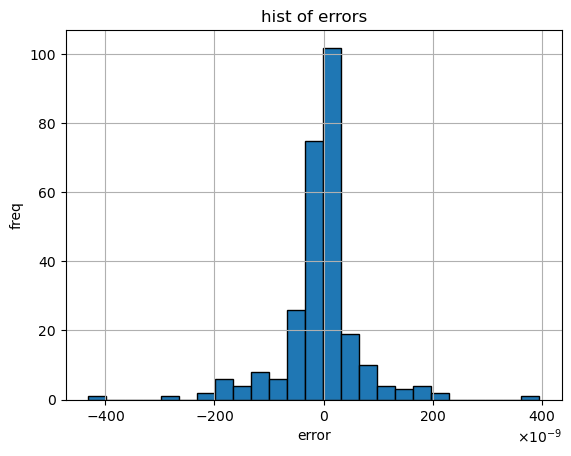

mu_error: -4.904960684064327e-09,      sigma_error : 7.33505185208777e-08


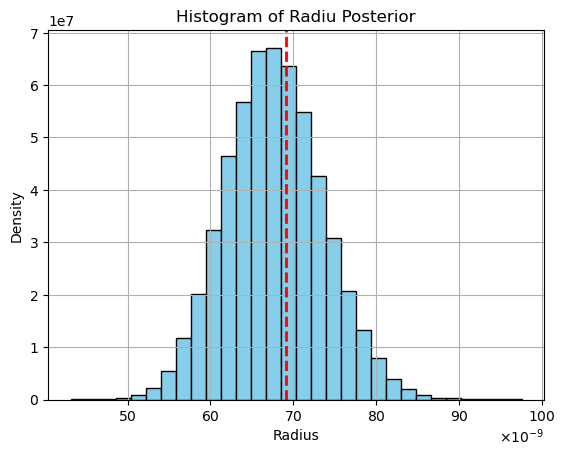

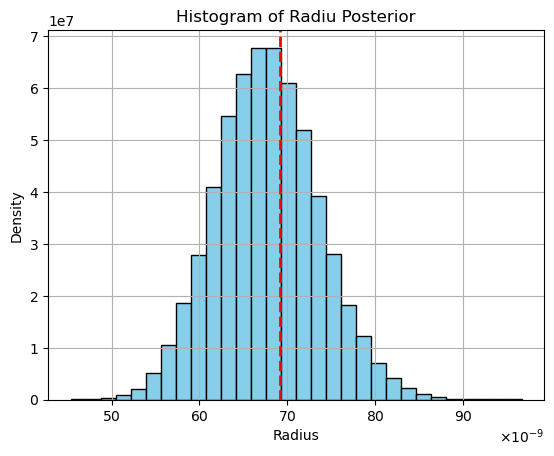

Particle 10, detections : 128
Minimum distance: 1.403944126778078e-07


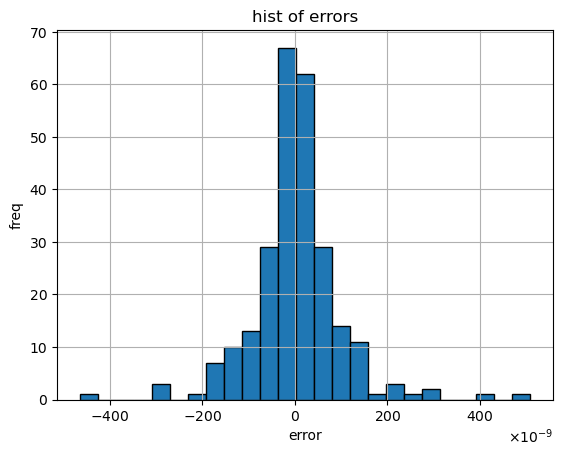

mu_error: 1.2031056856724541e-09,      sigma_error : 9.797033803914452e-08


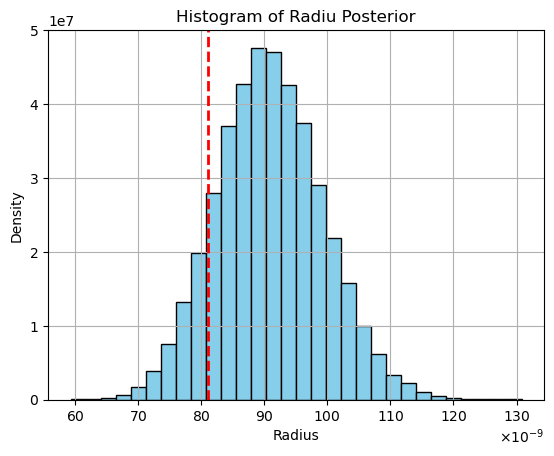

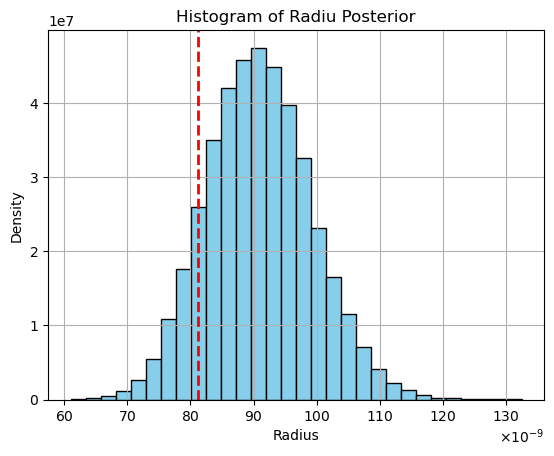

Particle 11, detections : 136
Minimum distance: 3.266345953691116e-08


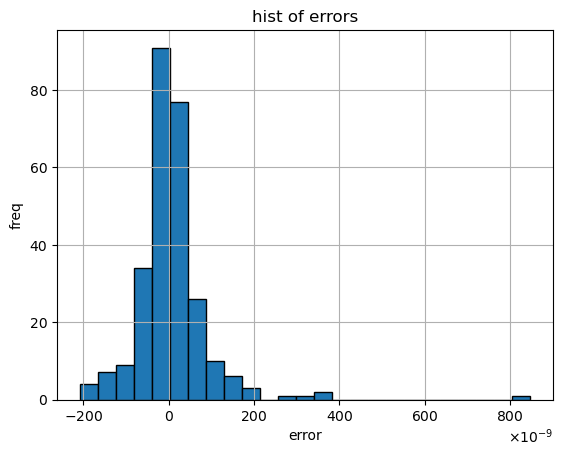

mu_error: 5.723369885454042e-09,      sigma_error : 8.963535816422556e-08


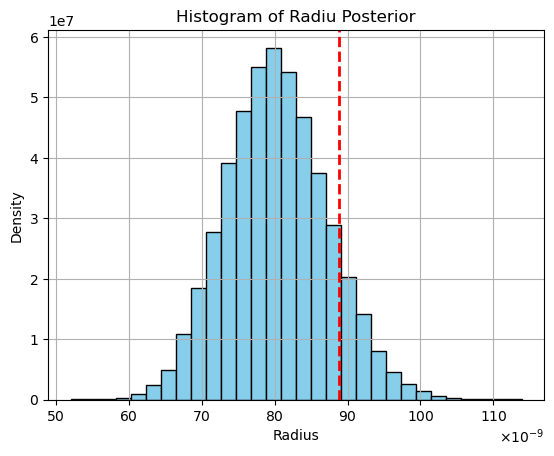

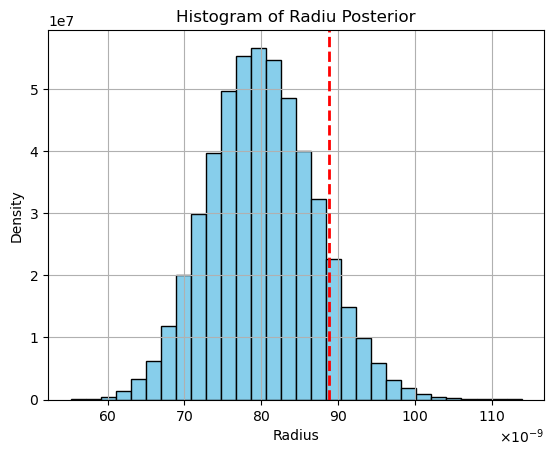

In [120]:
for tp_particle_num in tracks['particle'].unique():
    tp_track = tp_converted[tp_converted['particle'] == tp_particle_num]

    print(f"Particle {tp_particle_num}, detections : {len(tp_track)}")
    
    # get ground info (based on first trackPy frame with all particles)
    gnd_num, true_radius = get_ground_info(tp_track, ground, full_frame)


    # get error fit
    mu_error, sigma_error = get_error_info(tp_track, ground, gnd_num)
    print(f"mu_error: {mu_error},      sigma_error : {sigma_error}")


    ## run MCMC with estimated sigma_e2
    run_MCMC_with_error(tp_track, sigma_e2, true_radius, C, show_summary=False)

    ## run MCMC with no error consideration
    run_MCMC_with_error(tp_track, 0, true_radius, C, show_summary=False)
    
    

In [ ]:
for particle in tracks['particle'].unique():
    #print(particle)
    particle_df = tracks[tracks["particle"] == particle]

    #plt.plot(particle_df['frame'], particle_df['signal'])
    #plt.show()

In [ ]:
curr_particle = 5
particle_df = strong_tracks[strong_tracks["particle"] == 5]

for frame_num in range(0, 30):
    #display_particle(strong_tracks, test[frame_num], curr_particle, frame_number=frame_num, radius=20)
    pass

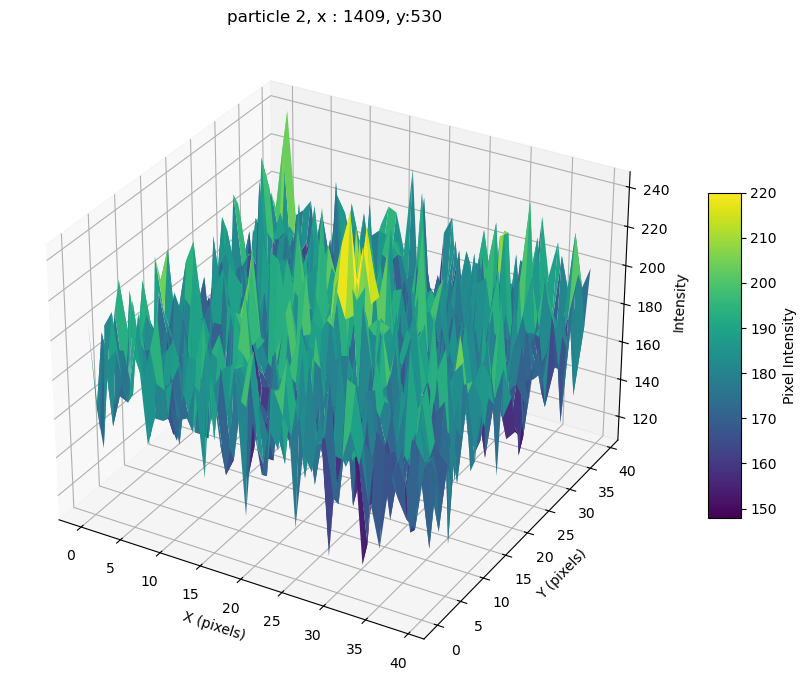

In [118]:
display_particle(tracks, sim[0], particle_number=2, frame_number=0, radius=20)